<a href="https://colab.research.google.com/github/LucianaNieto/Cambodia_2023/blob/main/2_SemanticSegmentation_Cambodia_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow==2.10 -q
#!pip install patchify -q
!pip install segmentation_models==0.2.1 -q
import tensorflow
tensorflow.__version__
!pip install segmentation_models==1.0.1 -q
#!pip install tensorboard -q
!pip install graphviz pydot -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.2 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
root_directory = '/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/'

In [7]:
patch_size = 512

In [28]:

# set the path of the folder containing the images
image_folder_path = "/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/aug_images_train"

# set the path of the folder containing the masks
mask_folder_path = "/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/aug_masks_train"

# count the number of files in the folder
num_files = len(os.listdir(mask_folder_path))

# print the result
print(f"The folder '{mask_folder_path}' contains {num_files} files.")


The folder '/content/drive/MyDrive/0_imgSeg_Cambodia/data/augData/aug_masks_train' contains 1296 files.


In [40]:
# get a list of all the image and mask file names
image_files = sorted(os.listdir(image_folder_path))
mask_files = sorted(os.listdir(mask_folder_path))

# make sure the number of images and masks are equal
assert len(image_files) == len(mask_files), "The number of images and masks are not equal"

# create empty numpy arrays to store the images and masks
images_np = np.zeros((len(image_files), 512, 512, 3), dtype=np.uint8)
masks_np = np.zeros((len(mask_files), 512, 512, 3), dtype=np.uint8)

# loop through each image and mask file and convert them to numpy arrays
for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
    #print(f"Processing files {i+1}/{len(image_files)}: {image_file}, {mask_file}")
    image_path = os.path.join(image_folder_path, image_file)
    mask_path = os.path.join(mask_folder_path, mask_file)
    image = Image.open(image_path).resize((512, 512))
    mask = Image.open(mask_path).resize((512, 512))
    image_np = np.array(image, dtype=np.uint8)
    mask_np = np.array(mask, dtype=np.uint8)
    images_np[i] = image_np
    masks_np[i] = mask_np

# check if the images and masks are aligned
assert images_np.shape[0] == masks_np.shape[0], "The number of images and masks are not equal"
assert images_np.shape[1:3] == masks_np.shape[1:3], "The images and masks are not aligned"


In [41]:
masks_np.shape

(1296, 512, 512, 3)

In [42]:
images_np.shape

(1296, 512, 512, 3)

In [43]:
"""
#3366CC (51, 102, 204) blueish road
#FF9900 (255, 153, 0) orange vegetation
#109618 (16, 150, 24) green forest
#990099 (153, 0, 153) purple burned
#0099C6 (0, 153, 198) lightblue baredsoil
#DD4477 (221, 68, 119) pink unclass              
"""
#Convert HEX to RGB array
#Do the same for all RGB channels in each hex code to convert to RGB
Road = '#3366CC'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) # 51, 102, 204

Vegetation = '#FF9900'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #255, 153, 0

Forest = '#109618'.lstrip('#') 
Forest = np.array(tuple(int(Forest[i:i+2], 16) for i in (0, 2, 4))) #16, 150, 24

Burned =  '#990099'.lstrip('#') 
Burned = np.array(tuple(int(Burned[i:i+2], 16) for i in (0, 2, 4))) #153, 0, 153

Bare = '#0099C6'.lstrip('#') 
Bare = np.array(tuple(int(Bare[i:i+2], 16) for i in (0, 2, 4))) #0, 153, 198

Unlabeled = '#DD4477'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #221, 68, 119

#label = single_patch_mask
label = mask_np
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Road,axis=-1)] = 0
    label_seg [np.all(label==Vegetation,axis=-1)] = 1
    label_seg [np.all(label==Forest,axis=-1)] = 2
    label_seg [np.all(label==Burned,axis=-1)] = 3
    label_seg [np.all(label==Bare,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(masks_np.shape[0]):
    label = rgb_to_2D_label(masks_np[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [44]:
labels.shape

(1296, 512, 512, 1)

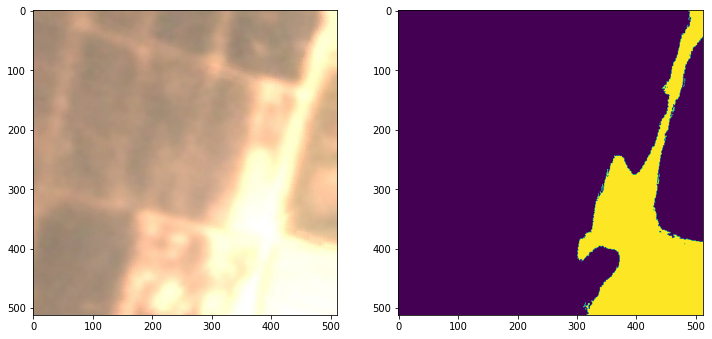

In [19]:
#Another Sanity check, view few mages

image_number = random.randint(0, len(images_np))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(images_np[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [34]:
##########new type of data ############
from sklearn.utils.class_weight import compute_class_weight
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)



In [ ]:
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=18, 
          epochs=150,
          verbose=1,
          validation_data=(X_test_prepr, y_test))


85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

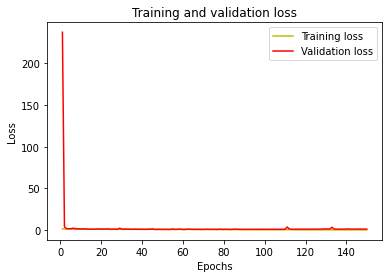

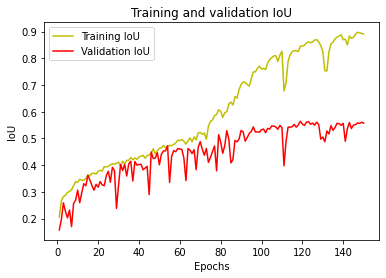

In [ ]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


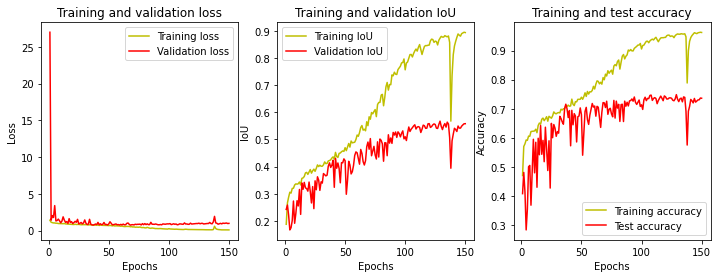

In [ ]:
import matplotlib.pyplot as plt

# get history from model training
history = history2

# extract training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# extract training and validation IoU
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

# extract training and test accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy'] ###

# create x-axis values for epochs
epochs = range(1, len(loss) + 1)

# plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot training and validation IoU
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# plot training and test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, train_acc, 'y', label='Training accuracy')
plt.plot(epochs, test_acc, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [63]:
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, f1_score
import numpy as np
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

tensorboard_callback = TensorBoard(log_dir='/content/drive/MyDrive/0_imgSeg_Cambodia/logs/my_logs')




def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

# Define number of folds
k = 4

# Define the data and labels
data = images_np
labels = labels_cat

# Initialize the K-fold object
kf = KFold(n_splits=k, shuffle=True, random_state=20)

# Define the ResNet model to be trained
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


# Define early stopper and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_jacard_coefs = []
fold_f1_scores = []
fold_confusion_matrices = []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")

    # Split data into training and test sets for this fold
    X_train = data[train_idx]
    y_train = labels[train_idx]
    X_test = data[test_idx]
    y_test = labels[test_idx]

    # Fit the model on the training data
    model_resnet_backbone.fit(
        x=preprocess_input(X_train),
        y=y_train,
        batch_size=10,
        epochs=100,
        validation_data=(preprocess_input(X_test), y_test),
        callbacks=[early_stop, tensorboard_callback]
    )

    # Get predictions for test set
    y_pred = model_resnet_backbone.predict(preprocess_input(X_test))
    y_pred_labels = np.argmax(y_pred, axis=-1)

    # Calculate accuracy, Jaccard coefficient, confusion matrix, and F-1 score
    accuracy = accuracy_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    jacard_coef = jaccard_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')
    confusion_matrix_values = confusion_matrix(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    f1 = f1_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')

        # Add metrics to lists for all folds
    fold_accuracies.append(accuracy)
    fold_jacard_coefs.append(jacard_coef)
    fold_f1_scores.append(f1)
    fold_confusion_matrices.append(confusion_matrix_values)
    # Clear memory
    del X_train, y_train, X_test, y_test, y_pred, y_pred_labels
    gc.collect()

#from keras.utils import plot_model
#plot_model(model_resnet_backbone, to_file='model.png', show_shapes=True)

Fold 1
Epoch 1/100
98/98 [==============================] - 47s 412ms/step - loss: 1.3549 - accuracy: 0.4731 - jacard_coef: 0.2048 - val_loss: 18.3312 - val_accuracy: 0.3715 - val_jacard_coef: 0.2146
Epoch 2/100
98/98 [==============================] - 33s 341ms/step - loss: 1.2021 - accuracy: 0.5412 - jacard_coef: 0.2518 - val_loss: 2.6867 - val_accuracy: 0.3679 - val_jacard_coef: 0.2059
Epoch 3/100
98/98 [==============================] - 37s 377ms/step - loss: 1.1576 - accuracy: 0.5534 - jacard_coef: 0.2655 - val_loss: 1.5776 - val_accuracy: 0.4087 - val_jacard_coef: 0.1699
Epoch 4/100
98/98 [==============================] - 33s 342ms/step - loss: 1.1286 - accuracy: 0.5654 - jacard_coef: 0.2763 - val_loss: 1.3467 - val_accuracy: 0.4821 - val_jacard_coef: 0.2491
Epoch 5/100
98/98 [==============================] - 36s 372ms/step - loss: 1.0742 - accuracy: 0.5851 - jacard_coef: 0.2939 - val_loss: 1.3863 - val_accuracy: 0.4118 - val_jacard_coef: 0.1960
Epoch 6/100
98/98 [=============

KeyboardInterrupt: ignored

In [73]:
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, f1_score
import numpy as np
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard


tensorboard_callback = TensorBoard(log_dir='/content/drive/MyDrive/0_imgSeg_Cambodia/logs/my_logs')

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

# Define number of folds
k = 4

# Define the data and labels
data = images_np
labels = labels_cat

# Initialize the K-fold object
kf = KFold(n_splits=k, shuffle=True, random_state=20)

# Define the EfficientNet model to be trained
BACKBONE = 'efficientnetb2'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_efficientnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_efficientnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# Define early stopper and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_jacard_coefs = []
fold_f1_scores = []
fold_confusion_matrices = []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")

    # Split data into training and test sets for this fold
    X_train = data[train_idx]
    y_train = labels[train_idx]
    X_test = data[test_idx]
    y_test = labels[test_idx]

    # Fit the model on the training data
    model_efficientnet_backbone.fit(
        x=preprocess_input(X_train),
        y=y_train,
        batch_size=10,
        epochs=100,
        validation_data=(preprocess_input(X_test), y_test),
        callbacks=[early_stop, tensorboard_callback]
    )

    # Get predictions for test set
    y_pred = model_efficientnet_backbone.predict(preprocess_input(X_test))
    y_pred_labels = np.argmax(y_pred, axis=-1)

    # Calculate accuracy, Jaccard coefficient, confusion matrix, and F-1 score
    accuracy = accuracy_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    jacard_coef = jaccard_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')
    confusion_matrix_values = confusion_matrix(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    f1 = f1_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')

        # Add metrics to lists for all folds
    fold_accuracies.append(accuracy)
    fold_jacard_coefs.append(jacard_coef)
    fold_f1_scores.append(f1)
    fold_confusion_matrices.append(confusion_matrix_values)
    # Clear memory
    del X_train, y_train, X_test, y_test, y_pred, y_pred_labels
    gc.collect()


31936256/31936256 [==============================] - 2s 0us/step
Fold 1
Epoch 1/100
98/98 [==============================] - 78s 639ms/step - loss: 1.2092 - accuracy: 0.5424 - jacard_coef: 0.2545 - val_loss: 5.2416 - val_accuracy: 0.5717 - val_jacard_coef: 0.3667
Epoch 2/100
98/98 [==============================] - 54s 551ms/step - loss: 1.0494 - accuracy: 0.6060 - jacard_coef: 0.3114 - val_loss: 2.1386 - val_accuracy: 0.5886 - val_jacard_coef: 0.3725
Epoch 3/100
98/98 [==============================] - 52s 530ms/step - loss: 0.9619 - accuracy: 0.6360 - jacard_coef: 0.3429 - val_loss: 1.0709 - val_accuracy: 0.5981 - val_jacard_coef: 0.3147
Epoch 4/100
98/98 [==============================] - 54s 558ms/step - loss: 0.9639 - accuracy: 0.6416 - jacard_coef: 0.3414 - val_loss: 0.8980 - val_accuracy: 0.6866 - val_jacard_coef: 0.4219
Epoch 5/100
98/98 [==============================] - 50s 517ms/step - loss: 0.9236 - accuracy: 0.6546 - jacard_coef: 0.3599 - val_loss: 0.9681 - val_accuracy: 0

In [74]:
# Print average metrics across all folds
print("Average accuracy:", np.mean(fold_accuracies))
print("Average Jaccard coefficient:", np.mean(fold_jacard_coefs))
print("Average f1:", np.mean(fold_f1_scores))
print("Average matrix:", np.mean(fold_confusion_matrices))

Average accuracy: 0.8793175544267819
Average Jaccard coefficient: 0.7176345091909149
Average f1: 0.8199190560352213
Average matrix: 2359296.0


In [75]:
fold_confusion_matrices

[array([[  734180,   212105,   230497,   521178,   328219,   125924],
        [  145286, 14795424,   304769,   178009,  1282831,  1581885],
        [  190172,   896184,  5687677,  1121705,    60348,   462253],
        [   31348,   134632,   193054, 22067878,  2004417,   765921],
        [  212839,   335268,   104714,  2374056, 17337016,   448072],
        [   66508,  1866337,   137530,  1508543,   761551,  5726326]]),
 array([[  856025,   182029,   133115,    65052,   199158,   114513],
        [   71956, 16881515,   162489,    28660,   461499,   421314],
        [  215396,   143624,  6322176,   187732,    39164,   355535],
        [   38770,   209843,   121887, 24601162,  1075286,   444949],
        [  233075,   841030,    66235,  1203730, 19607342,   143685],
        [   46350,   971253,    99862,   247083,   122505,  8019657]]),
 array([[  922278,   176937,   155691,    81607,   217312,    54942],
        [   96508, 17390094,    88792,    27961,   792911,   195407],
        [  18419

In [76]:
fold_accuracies

[0.7811711276019061, 0.89819492528468, 0.9176103686109002, 0.9202937962096415]

In [77]:
fold_jacard_coefs

[0.5625760480060813,
 0.7416891388169713,
 0.7761864904322452,
 0.7900863595083618]

In [78]:
fold_f1_scores

[0.7041530744286518,
 0.8403056473614251,
 0.8627831992646048,
 0.8724343030862033]

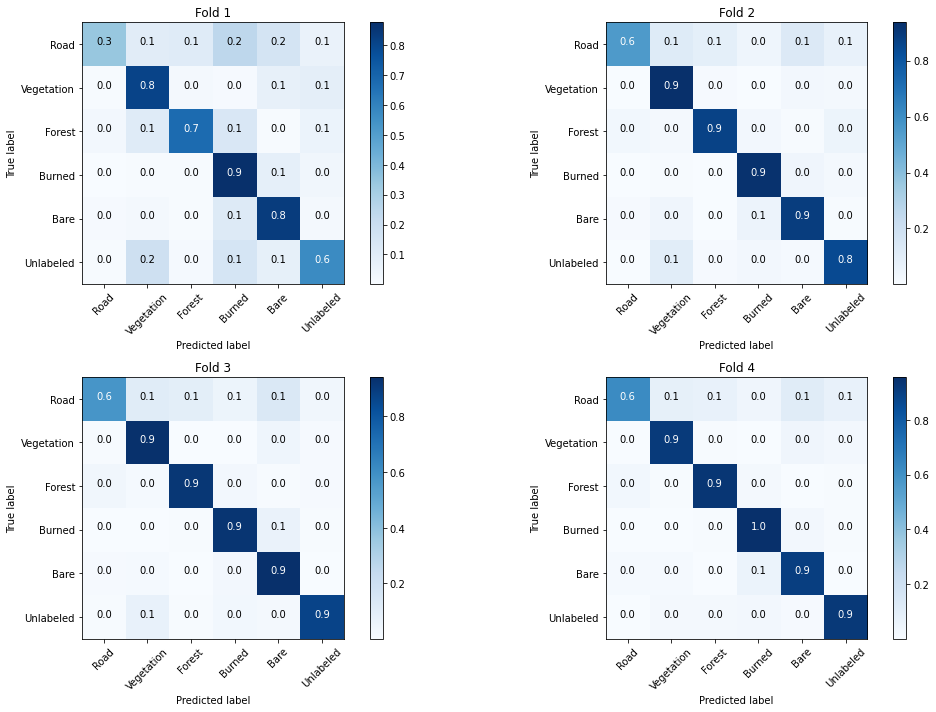

In [79]:

# Define las matrices de confusión como arrays
cm1 = np.array([[  734180,   212105,   230497,   521178,   328219,   125924],
        [  145286, 14795424,   304769,   178009,  1282831,  1581885],
        [  190172,   896184,  5687677,  1121705,    60348,   462253],
        [   31348,   134632,   193054, 22067878,  2004417,   765921],
        [  212839,   335268,   104714,  2374056, 17337016,   448072],
        [   66508,  1866337,   137530,  1508543,   761551,  5726326]])

cm2 = np.array([[  856025,   182029,   133115,    65052,   199158,   114513],
        [   71956, 16881515,   162489,    28660,   461499,   421314],
        [  215396,   143624,  6322176,   187732,    39164,   355535],
        [   38770,   209843,   121887, 24601162,  1075286,   444949],
        [  233075,   841030,    66235,  1203730, 19607342,   143685],
        [   46350,   971253,    99862,   247083,   122505,  8019657]])

cm3 = np.array([[  922278,   176937,   155691,    81607,   217312,    54942],
        [   96508, 17390094,    88792,    27961,   792911,   195407],
        [  184193,    86892,  5419023,   145608,    35251,    66467],
        [   66391,    60387,   157342, 26871120,  1843792,   194291],
        [  204135,   297717,    83584,   577234, 20599289,   107640],
        [   40200,   548409,    63619,   215985,   130530,  6735117]])

cm4 = np.array([[  1196824,   156414,   144154,    79989,   211781,   135756],
        [   83455, 16644009,   151296,    48627,   725727,   485287],
        [  249570,    70357,  7882392,   148613,    31675,    78074],
        [   97159,    47802,   180349, 24283930,   629268,   163290],
        [  316654,   356297,    79463,  1338694, 20154821,    65908],
        [   42868,   154422,   173350,   234003,    89517,  8002861]])



import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define la función para trazar una sola matriz de confusión
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues, ax=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, '{:.1f}'.format(np.round(cm[i, j], 1)), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


# Crear una lista de matrices de confusión
confusion_matrices = [cm1, cm2, cm3, cm4]

# Crear la figura con varias subtramas
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Lista de clases

classes = ["Road","Vegetation","Forest","Burned","Bare","Unlabeled"]

# Iterar a través de las matrices de confusión y trazar cada una en una subtrama diferente
for i, ax in enumerate(axs.flat):
    ax.set_position([0.1, 0.1, 0.8, 0.8])  # Establecer las dimensiones de la subtrama
    plot_confusion_matrix(confusion_matrices[i], classes, title=f'Fold {i+1}', ax=ax)


# Ajustar el diseño de la figura y mostrar el plot
plt.tight_layout()
plt.show()


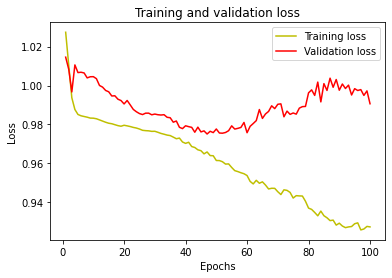

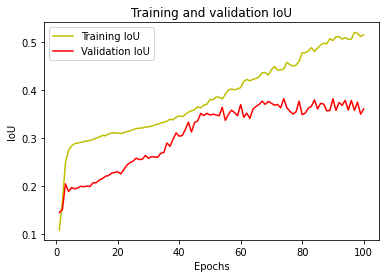

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


In [80]:
#IOU

y_pred=model_efficientnet_backbone.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_efficientnet_backbone.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

NameError: ignored

Fold 1
Epoch 1/100
98/98 [==============================] - 79s 651ms/step - loss: 1.2127 - accuracy: 0.5413 - jacard_coef: 0.2637 - val_loss: 1.6659 - val_accuracy: 0.4990 - val_jacard_coef: 0.3193
Epoch 2/100
98/98 [==============================] - 55s 569ms/step - loss: 1.0207 - accuracy: 0.6141 - jacard_coef: 0.3182 - val_loss: 1.2628 - val_accuracy: 0.6082 - val_jacard_coef: 0.3771
Epoch 3/100
98/98 [==============================] - 57s 581ms/step - loss: 0.9737 - accuracy: 0.6325 - jacard_coef: 0.3428 - val_loss: 1.1227 - val_accuracy: 0.5565 - val_jacard_coef: 0.3238
Epoch 4/100
98/98 [==============================] - 57s 586ms/step - loss: 0.9277 - accuracy: 0.6482 - jacard_coef: 0.3557 - val_loss: 1.1318 - val_accuracy: 0.6018 - val_jacard_coef: 0.3450
Epoch 5/100
98/98 [==============================] - 54s 552ms/step - loss: 0.8989 - accuracy: 0.6656 - jacard_coef: 0.3740 - val_loss: 0.8551 - val_accuracy: 0.6750 - val_jacard_coef: 0.4097
Epoch 6/100
98/98 [==============

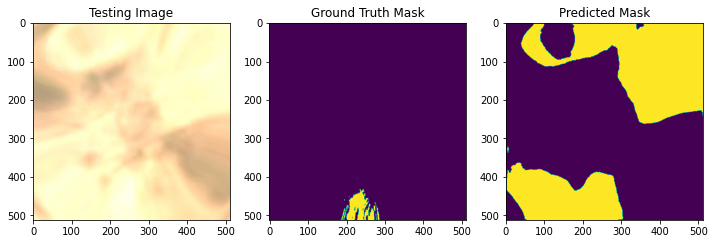

Fold 2
Epoch 1/100
98/98 [==============================] - 57s 583ms/step - loss: 0.6975 - accuracy: 0.7478 - jacard_coef: 0.4754 - val_loss: 0.6009 - val_accuracy: 0.7803 - val_jacard_coef: 0.5197
Epoch 2/100
98/98 [==============================] - 56s 574ms/step - loss: 0.7026 - accuracy: 0.7472 - jacard_coef: 0.4714 - val_loss: 0.6484 - val_accuracy: 0.7673 - val_jacard_coef: 0.5250
Epoch 3/100
98/98 [==============================] - 54s 557ms/step - loss: 0.6488 - accuracy: 0.7681 - jacard_coef: 0.4980 - val_loss: 0.6441 - val_accuracy: 0.7748 - val_jacard_coef: 0.5379
Epoch 4/100
98/98 [==============================] - 52s 536ms/step - loss: 0.6831 - accuracy: 0.7540 - jacard_coef: 0.4849 - val_loss: 0.6469 - val_accuracy: 0.7946 - val_jacard_coef: 0.5518
Epoch 5/100
98/98 [==============================] - 54s 559ms/step - loss: 0.6599 - accuracy: 0.7610 - jacard_coef: 0.4930 - val_loss: 0.6700 - val_accuracy: 0.7582 - val_jacard_coef: 0.5072
Epoch 6/100
98/98 [==============

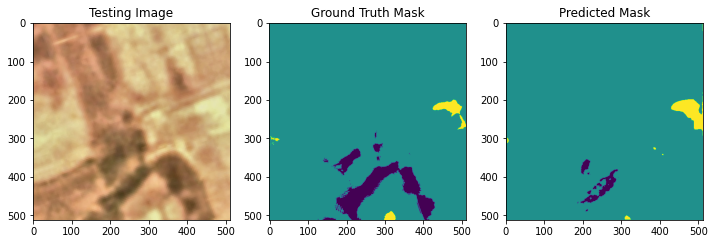

Fold 3
Epoch 1/100
98/98 [==============================] - 57s 584ms/step - loss: 0.6039 - accuracy: 0.7801 - jacard_coef: 0.5281 - val_loss: 0.4499 - val_accuracy: 0.8414 - val_jacard_coef: 0.6224
Epoch 2/100
98/98 [==============================] - 55s 560ms/step - loss: 0.5911 - accuracy: 0.7923 - jacard_coef: 0.5399 - val_loss: 0.4821 - val_accuracy: 0.8203 - val_jacard_coef: 0.6070
Epoch 3/100
98/98 [==============================] - 55s 560ms/step - loss: 0.5539 - accuracy: 0.7986 - jacard_coef: 0.5465 - val_loss: 0.4043 - val_accuracy: 0.8556 - val_jacard_coef: 0.6433
Epoch 4/100
98/98 [==============================] - 53s 541ms/step - loss: 0.5401 - accuracy: 0.8027 - jacard_coef: 0.5593 - val_loss: 0.5632 - val_accuracy: 0.7925 - val_jacard_coef: 0.5446
Epoch 5/100
98/98 [==============================] - 49s 506ms/step - loss: 0.5487 - accuracy: 0.7983 - jacard_coef: 0.5561 - val_loss: 0.4942 - val_accuracy: 0.8194 - val_jacard_coef: 0.6177
Epoch 6/100
98/98 [==============

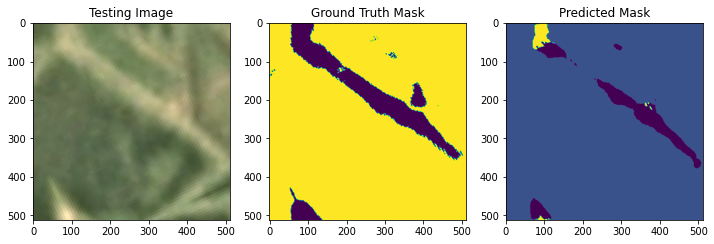

Fold 4
Epoch 1/100
98/98 [==============================] - 60s 608ms/step - loss: 0.5496 - accuracy: 0.8032 - jacard_coef: 0.5599 - val_loss: 0.4440 - val_accuracy: 0.8401 - val_jacard_coef: 0.6277
Epoch 2/100
98/98 [==============================] - 56s 575ms/step - loss: 0.5154 - accuracy: 0.8162 - jacard_coef: 0.5785 - val_loss: 0.4392 - val_accuracy: 0.8510 - val_jacard_coef: 0.5968
Epoch 3/100
98/98 [==============================] - 59s 611ms/step - loss: 0.4947 - accuracy: 0.8233 - jacard_coef: 0.5880 - val_loss: 0.4131 - val_accuracy: 0.8516 - val_jacard_coef: 0.6547
Epoch 4/100
98/98 [==============================] - 60s 620ms/step - loss: 0.5120 - accuracy: 0.8180 - jacard_coef: 0.5849 - val_loss: 0.5125 - val_accuracy: 0.8088 - val_jacard_coef: 0.5708
Epoch 5/100
98/98 [==============================] - 56s 571ms/step - loss: 0.4658 - accuracy: 0.8355 - jacard_coef: 0.6071 - val_loss: 0.3984 - val_accuracy: 0.8585 - val_jacard_coef: 0.6358
Epoch 6/100
98/98 [==============

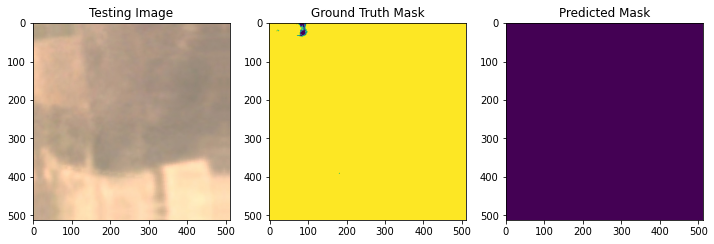

In [82]:
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, f1_score
import numpy as np
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.metrics import MeanIoU
import random
import matplotlib.pyplot as plt

tensorboard_callback = TensorBoard(log_dir='/content/drive/MyDrive/0_imgSeg_Cambodia/logs/my_logs')

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

# Define number of folds
k = 4

# Define the data and labels
data = images_np
labels = labels_cat

# Initialize the K-fold object
kf = KFold(n_splits=k, shuffle=True, random_state=20)

# Define the EfficientNet model to be trained
BACKBONE = 'efficientnetb2'
preprocess_input = sm.get_preprocessing(BACKBONE)
model_efficientnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_efficientnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# Define early stopper and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_jacard_coefs = []
fold_f1_scores = []
fold_confusion_matrices = []
fold_iou_scores = []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")

    # Split data into training and test sets for this fold
    X_train = data[train_idx]
    y_train = labels[train_idx]
    X_test = data[test_idx]
    y_test = labels[test_idx]

    # Fit the model on the training data
    model_efficientnet_backbone.fit(
        x=preprocess_input(X_train),
        y=y_train,
        batch_size=10,
        epochs=100,
        validation_data=(preprocess_input(X_test), y_test),
        callbacks=[early_stop, tensorboard_callback]
    )

    # Get predictions for test set
    y_pred = model_efficientnet_backbone.predict(preprocess_input(X_test))
    y_pred_labels = np.argmax(y_pred, axis=-1)

    # Calculate accuracy, Jaccard coefficient, confusion matrix, and F-1 score
    accuracy = accuracy_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    jacard_coef = jaccard_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')
    confusion_matrix_values = confusion_matrix(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel())
    f1 = f1_score(np.argmax(y_test, axis=-1).ravel(), y_pred_labels.ravel(), average='macro')

    # Add metrics to lists for all folds
    fold_accuracies.append(accuracy)
    fold_jacard_coefs.append(jacard_coef)
    fold_f1_scores.append(f1)
    fold_confusion_matrices.append(confusion_matrix_values)

    # Get a random test image and its corresponding ground truth mask and predicted mask
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth_mask = np.argmax(y_test[test_img_number], axis=-1)
    predicted_mask = np.argmax(y_pred[test_img_number], axis=-1)

    # Plot the images
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(132)
    plt.title('Ground Truth Mask')
    plt.imshow(ground_truth_mask)
    plt.subplot(133)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask)
    plt.show()

    # Clear memory
    del X_train, y_train, X_test, y_test, y_pred, y_pred_labels
    gc.collect()
